# Finding the Higgs Boson
These data are taken from <doi:10.7483/OPENDATA.CMS.8FLU.UIQJ>, which uses simulations to reproduce the 2012 CMS data.

In [1]:
import awkward as ak
import numpy as np
import hist
import particle
import hepunits
import vector
vector.register_awkward()

Load some data

In [2]:
raw_events = ak.from_parquet("data/SMHiggsToZZTo4L.parquet")

raw_events.type.show()

299973 * {
    run: int32,
    luminosityBlock: int64,
    event: uint64,
    PV_npvs: int32,
    PV_x: float32,
    PV_y: float32,
    PV_z: float32,
    nMuon: int64,
    Muon_pt: var * float32,
    Muon_eta: var * float32,
    Muon_phi: var * float32,
    Muon_mass: var * float32,
    Muon_charge: var * int32,
    Muon_pfRelIso03_all: var * float32,
    Muon_pfRelIso04_all: var * float32,
    Muon_dxy: var * float32,
    Muon_dxyErr: var * float32,
    Muon_dz: var * float32,
    Muon_dzErr: var * float32,
    nElectron: int64,
    Electron_pt: var * float32,
    Electron_eta: var * float32,
    Electron_phi: var * float32,
    Electron_mass: var * float32,
    Electron_charge: var * int32,
    Electron_pfRelIso03_all: var * float32,
    Electron_dxy: var * float32,
    Electron_dxyErr: var * float32,
    Electron_dz: var * float32,
    Electron_dzErr: var * float32,
    MET_pt: float32,
    MET_phi: float32
}


Let's restructure this to take advantage of structural operations.

In [3]:
def make_record_from_prefix(arr, prefix, name):
    prefix_with_separator = f"{prefix}_"
    arr_items = ak.unzip(arr, how=dict).items()
    structure = {
       n.removeprefix(prefix_with_separator): v for n, v in arr_items
       if n.startswith(prefix_with_separator)
    }
    return ak.zip(structure, with_name=name)

events = ak.zip({
    "muons": make_record_from_prefix(raw_events, "Muon", "Momentum4D"),
    "electrons": make_record_from_prefix(raw_events, "Electron", "Momentum4D"),
}, depth_limit=1)

events.type.show()

299973 * {
    muons: var * Momentum4D[
        pt: float32,
        eta: float32,
        phi: float32,
        mass: float32,
        charge: int32,
        pfRelIso03_all: float32,
        pfRelIso04_all: float32,
        dxy: float32,
        dxyErr: float32,
        dz: float32,
        dzErr: float32
    ],
    electrons: var * Momentum4D[
        pt: float32,
        eta: float32,
        phi: float32,
        mass: float32,
        charge: int32,
        pfRelIso03_all: float32,
        dxy: float32,
        dxyErr: float32,
        dz: float32,
        dzErr: float32
    ]
}


## H → ZZ* → 4μ or 4e

Find events consisting of four same-flavour leptons

In [4]:
four_muons = ak.combinations(events.muons, 4)
four_electrons = ak.combinations(events.electrons, 4)

Compute the invariant mass of the frame
$$
M_0^2 = \left(\sum_i E_i\right)^{2}-\left\|\sum_i \mathbf {p}_i\right\|^{2}
$$
by adding together all of the four-momentum vectors 
$$
p=\left(p^{0},p^{1},p^{2},p^{3}\right)=\left({\frac {E}{c}},p_{x},p_{y},p_{z}\right).
$$

In [5]:
four_muons_mass = (four_muons['0'] + four_muons['1'] + four_muons['2'] + four_muons['3']).mass
four_electrons_mass = (four_electrons['0'] + four_electrons['1'] + four_electrons['2'] + four_electrons['3']).mass

Histogram the result

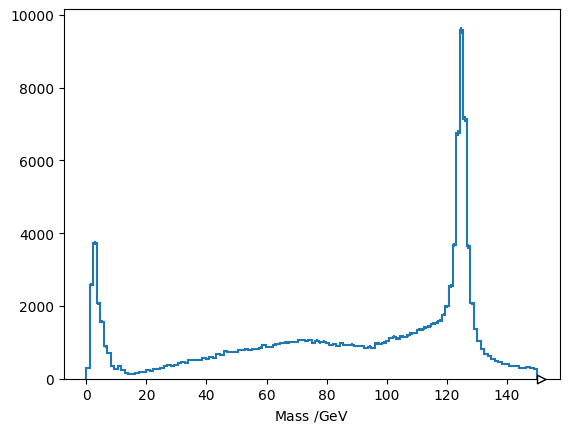

In [6]:
#| label: zz-eeee-uuuu
(
    hist.Hist.new.Reg(128, 0, 150, label="Mass /$\\text{GeV}$")
    .Double()
    .fill_flattened(four_muons_mass)
    .fill_flattened(four_electrons_mass)
).plot();

## H → ZZ* → 2μ2e

In [7]:
muons_plus = events.muons[events.muons.charge > 0]
muons_minus = events.muons[events.muons.charge < 0]

electrons_plus = events.electrons[events.electrons.charge > 0]
electrons_minus = events.electrons[events.electrons.charge < 0]

In [8]:
muon_plus, muon_minus, electron_plus, electron_minus = ak.unzip(
    ak.cartesian(
        (muons_plus, muons_minus, electrons_plus, electrons_minus)
    )
)

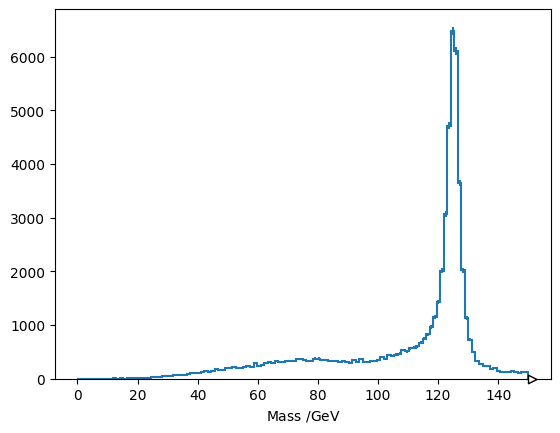

In [9]:
#| label: zz-2u2e
(
    hist.Hist.new.Reg(128, 0, 150, label="Mass /$\\text{GeV}$")
    .Double()
    .fill_flattened((muon_plus + muon_minus + electron_plus + electron_minus).mass)
).plot();

For e+e-e+e- events (or muon equivalent), we can combine e+e- in two pairings. We usually find an "on-shell" Z that has close to the Z mass. We can cut according to this heuristic

In [10]:
ZMASS = particle.Particle.findall("Z0")[0].mass / hepunits.GeV
ZMASS

91.188

In [11]:
is_on_shell_z_muon = np.abs((muon_plus + muon_minus).mass - ZMASS) < 20
is_on_shell_z_electron = np.abs((electron_plus + electron_minus).mass - ZMASS) < 20

In [12]:
is_on_shell_z = is_on_shell_z_muon | is_on_shell_z_electron

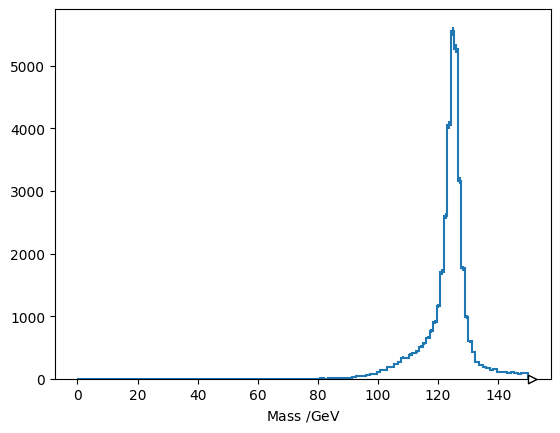

In [13]:
#| label: on-shell-zz-2u2e
(
    hist.Hist.new.Reg(128, 0, 150, label="Mass /$\\text{GeV}$")
    .Double()
    .fill_flattened(
        (muon_plus + muon_minus + electron_plus + electron_minus).mass[is_on_shell_z]
    )
).plot();